Imports
---

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Data ([Source](https://beta.data.gov.sg/collections/395/view))
---

In [2]:
# Load data
df = pd.read_csv('../data/MFTrawdata.csv')
print(df.shape)
df.head()

(2007, 101)


,respondent_serial,respondent_id,country,yearbornin_1_slice,yearbornin_1_slice1,ageofrespondent,indicateage,gender,occstatus,levelsch,...,ban_q30_4,ban_q32,ban_q431,ban_q432,ban_q433,ban_q434,ban_q435,ban_q436,ban_q437,md_segment
0,1184,GEN24_ 2833,Singapore,1961,60,60,55-64 years old,Female,Housewife / homemaker,-,...,T2B,Neutral,No,No,Yes,No,No,No,Yes,Loyal_betrayal
1,730,GEN24_.2328.,Singapore,1951,70,70,65 years old and above,Female,Employee (working full-time in private sector),-,...,T2B,Neutral,No,No,Yes,No,No,No,Yes,Harm_Care
2,15,GEN24_1001,Singapore,1983,38,38,35-44 years old,Male,Employee (working full-time in private sector),-,...,Neutral,B2B,No,No,No,Yes,No,Yes,No,Fairness_Cheating
3,18,GEN24_1002,Singapore,1955,66,66,65 years old and above,Male,Retiree,-,...,T2B,Neutral,No,No,Yes,No,No,Yes,No,Harm_Care
4,23,GEN24_1003,Singapore,1965,56,56,55-64 years old,Female,Housewife / homemaker,-,...,T2B,B2B,No,No,No,Yes,No,Yes,No,Purity_Degradation


Preparation
---

In [3]:
# Count missing values in each column
missing_values_count = df.isnull().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values_count[missing_values_count > 0]

# Print the columns and the count of missing values
print("Columns with missing values and their counts:")
print(columns_with_missing_values)

Columns with missing values and their counts:
Series([], dtype: int64)


In [4]:
# Function to check for columns with a lot of non-meaningful data indicated by "-"
def check_non_meaningful_data(df):
    non_meaningful_data_summary = {}
    for column in df.columns:
        non_meaningful_percentage = df[column].value_counts(normalize=True).get('-', 0) * 100
        if non_meaningful_percentage > 0:
            non_meaningful_data_summary[column] = non_meaningful_percentage
    return non_meaningful_data_summary

# Function to check for columns with no variance
def check_no_variance(df):
    no_variance_summary = {}
    for column in df.columns:
        if df[column].nunique() == 1:
            no_variance_summary[column] = 100.0  # 100% non-variance
    return no_variance_summary

# Generate the summary of columns with non-meaningful data
non_meaningful_data_summary = check_non_meaningful_data(df)

# Generate the summary of columns with no variance
no_variance_summary = check_no_variance(df)

# Convert to DataFrames for better visualization
non_meaningful_data_summary_df = pd.DataFrame(non_meaningful_data_summary.items(), columns=['Column', 'Percentage Non-Meaningful']).sort_values(by='Percentage Non-Meaningful', ascending=False)
no_variance_summary_df = pd.DataFrame(no_variance_summary.items(), columns=['Column', 'Percentage Non-Variance']).sort_values(by='Percentage Non-Variance', ascending=False)

# Display the results
print("Columns with greater than 0% non-meaningful data:")
print(non_meaningful_data_summary_df)

print("\nColumns with no variance:")
print(no_variance_summary_df)

Columns with greater than 0% non-meaningful data:
                  Column  Percentage Non-Meaningful
2            postgradsch                  95.615346
0               levelsch                  89.187843
1                 unisch                  72.247135
8               q20_q213                  67.862481
7               q20_q212                  67.862481
6               q20_q211                  67.862481
9               q20_q214                  67.862481
15        ban_education4                  67.862481
12        ban_education1                  67.862481
13        ban_education2                  67.862481
14        ban_education3                  67.862481
25      ban_age_youngest                  38.614848
4           noofchildren                  38.614848
5               childage                  38.614848
24     ban_no_ofchildren                  38.614848
11               ban_mhi                  24.663677
10      ban_personal_inc                  12.107623
17  ban_occupa

In [5]:
# Specify the columns to drop
columns_to_drop = [
    'postgradsch', 'levelsch', 'unisch', 'q20_q213', 'q20_q212', 
    'q20_q211', 'q20_q214', 'ban_education4', 'ban_education1', 
    'ban_education2', 'ban_education3', 'ban_age_youngest', 'noofchildren', 
    'childage', 'ban_no_ofchildren', 'country'
]

# Drop the specified columns from the dataframe
filtered_df = df.drop(columns=columns_to_drop)
print(filtered_df.shape)

(2007, 85)


In [6]:
# Impute column on monthly household income
mode_value = filtered_df['ban_mhi'].mode()[0]
filtered_df['ban_mhi'] = filtered_df['ban_mhi'].replace('-', mode_value)
filtered_df['ban_mhi'].value_counts()

ban_mhi
Medium ($4k to $9.9k)    1149
Low (below $4k)           537
High ($10k and above)     321
Name: count, dtype: int64

In [7]:
# Filter rows with non-meaningful values
filtered_df = filtered_df[~filtered_df.eq('-', axis=0).any(axis=1)]
print(filtered_df.shape)

(1546, 85)


EDA
---

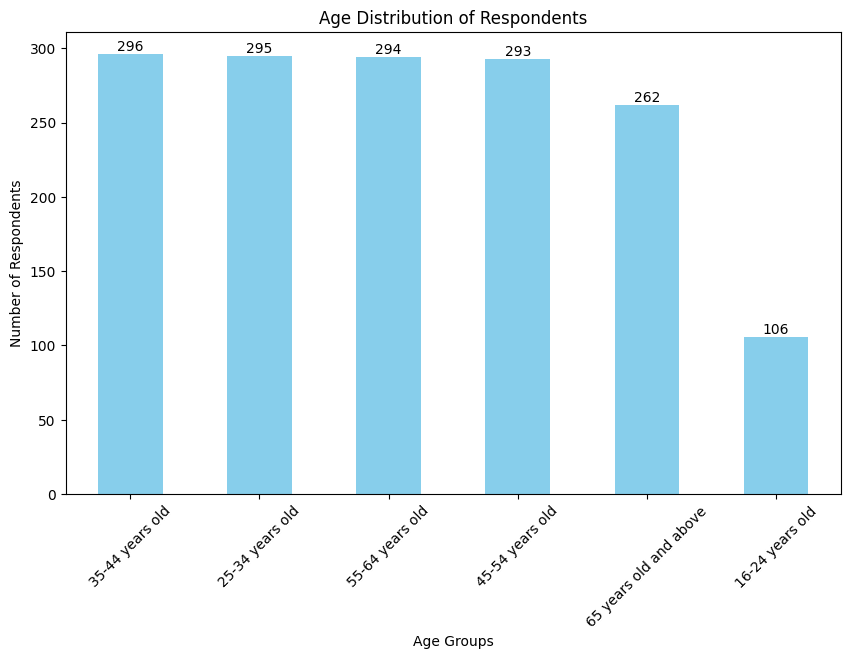

In [8]:
# Plot age distribution
age_distribution = filtered_df['indicateage'].value_counts()
plt.figure(figsize=(10, 6))
ax = age_distribution.plot(kind='bar', color='skyblue')

# Add labels to the bars
ax.bar_label(ax.containers[0])

plt.xlabel('Age Groups')
plt.ylabel('Number of Respondents')
plt.title('Age Distribution of Respondents')
plt.xticks(rotation=45)
plt.show()

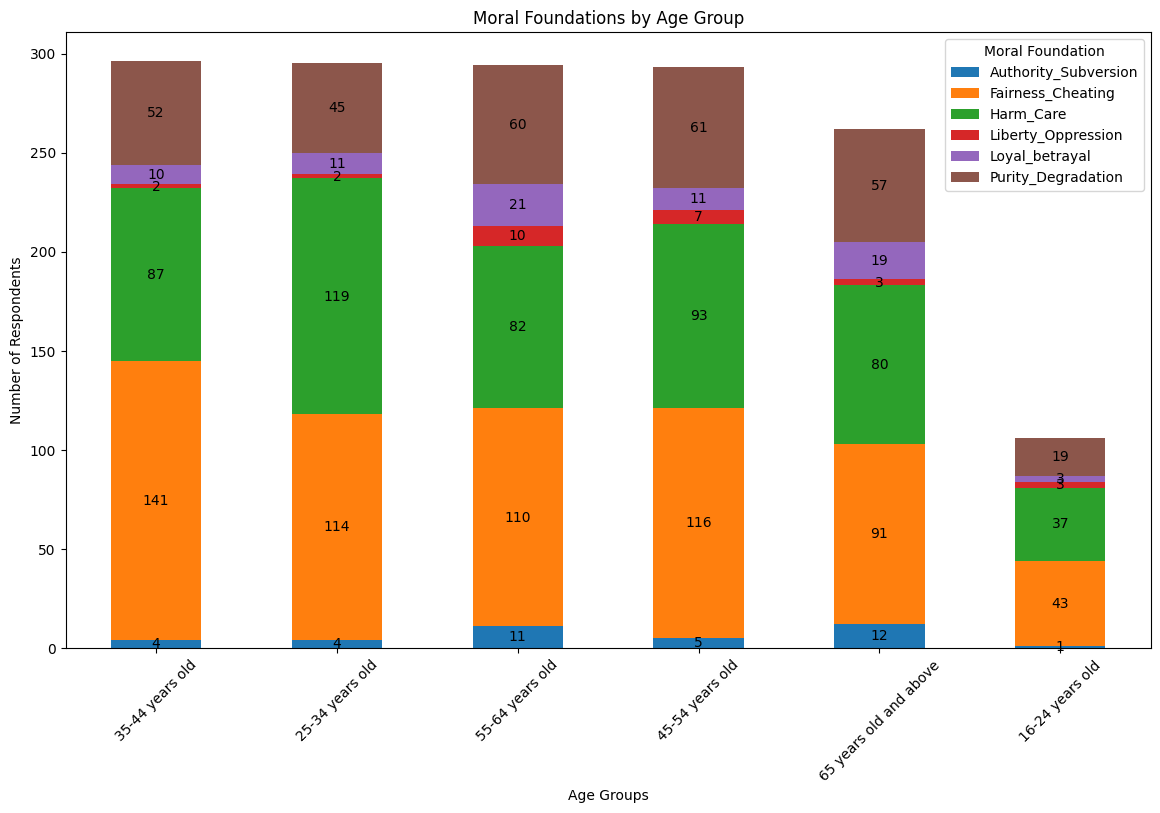

In [9]:
# Ensure age groups are sorted in the same order as the age distribution chart
age_group_order = age_distribution.index

# Grouping data by age group and moral foundation segment, ensuring the order matches the age distribution chart
moral_foundation_age_ordered = filtered_df.groupby(['indicateage', 'md_segment']).size().unstack(fill_value=0).loc[age_group_order]

# Plotting the moral foundations by age group in the same order as previous chart
fig, ax = plt.subplots(figsize=(14, 8))
moral_foundation_age_ordered.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('Age Groups')
plt.ylabel('Number of Respondents')
plt.title('Moral Foundations by Age Group')
plt.xticks(rotation=45)
plt.legend(title='Moral Foundation')

# Adding labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.show()


In [10]:
# Quantify predominant moral foundation segments
len(filtered_df[filtered_df['md_segment'].isin(['Fairness_Cheating', 'Harm_Care'])])/len(filtered_df)

0.7199223803363519

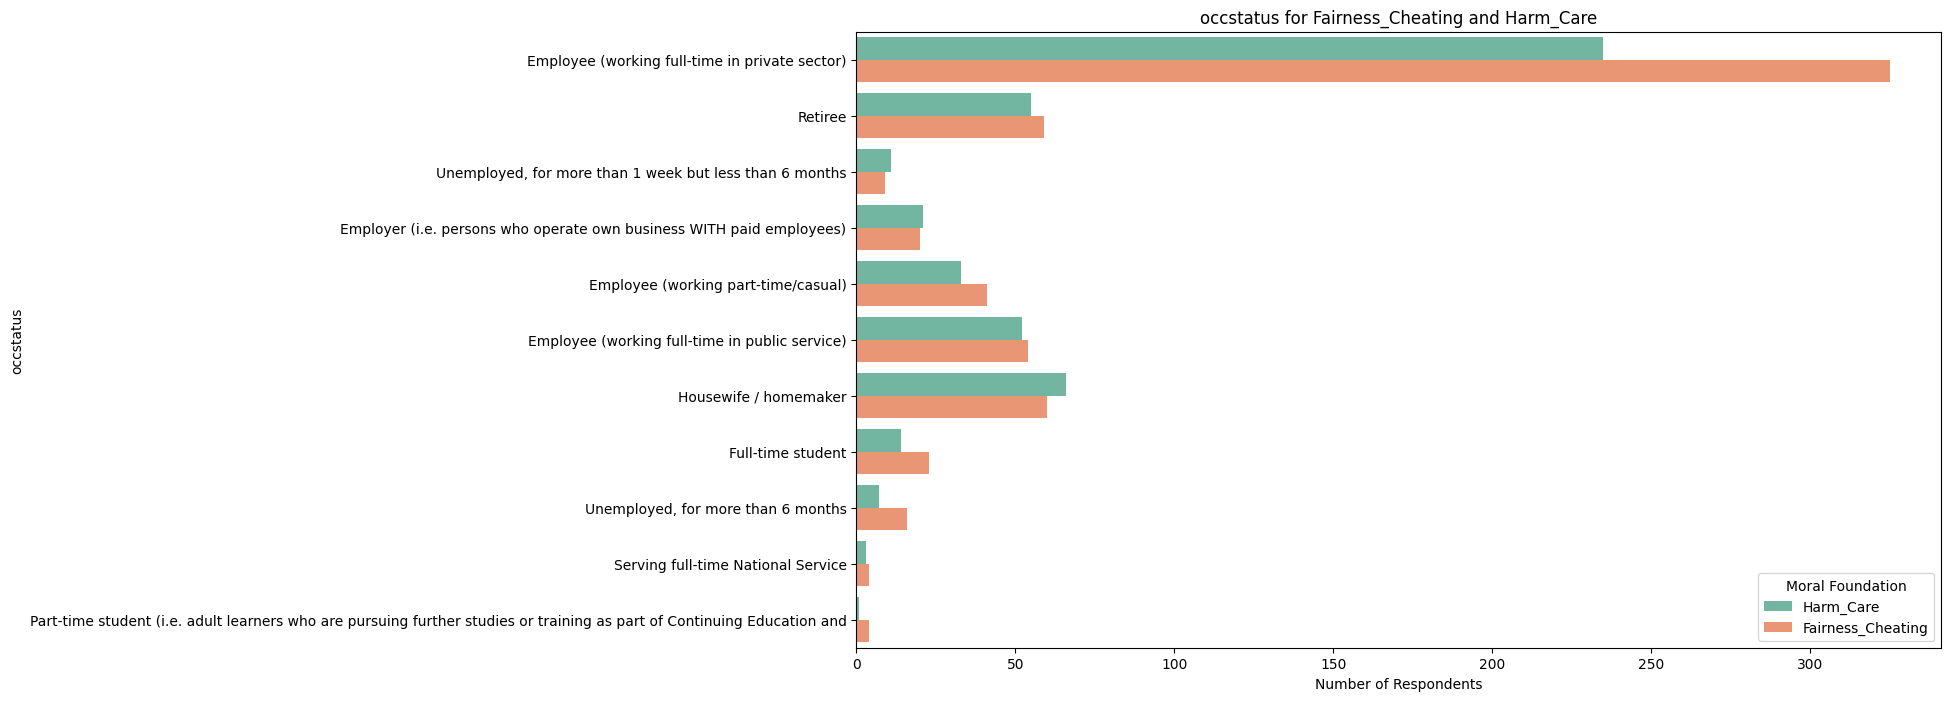

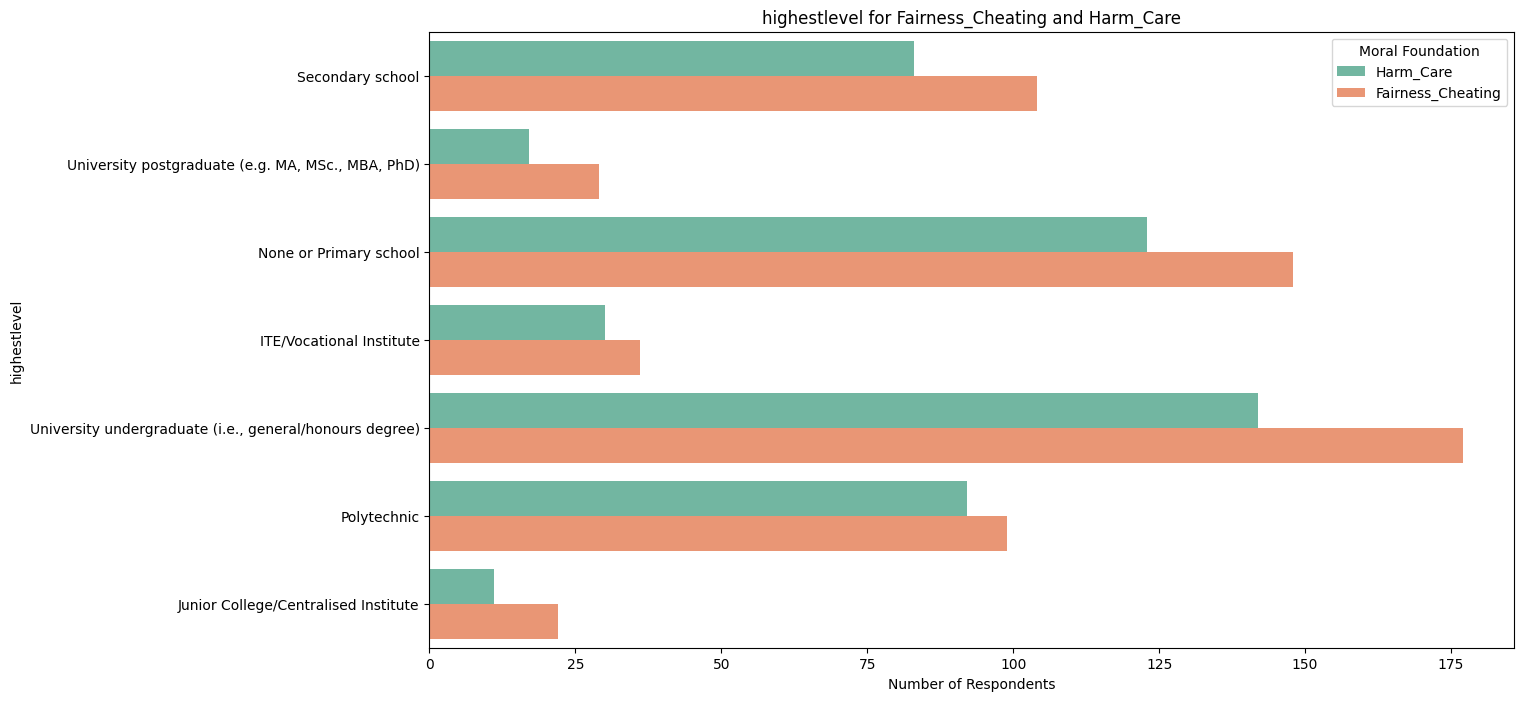

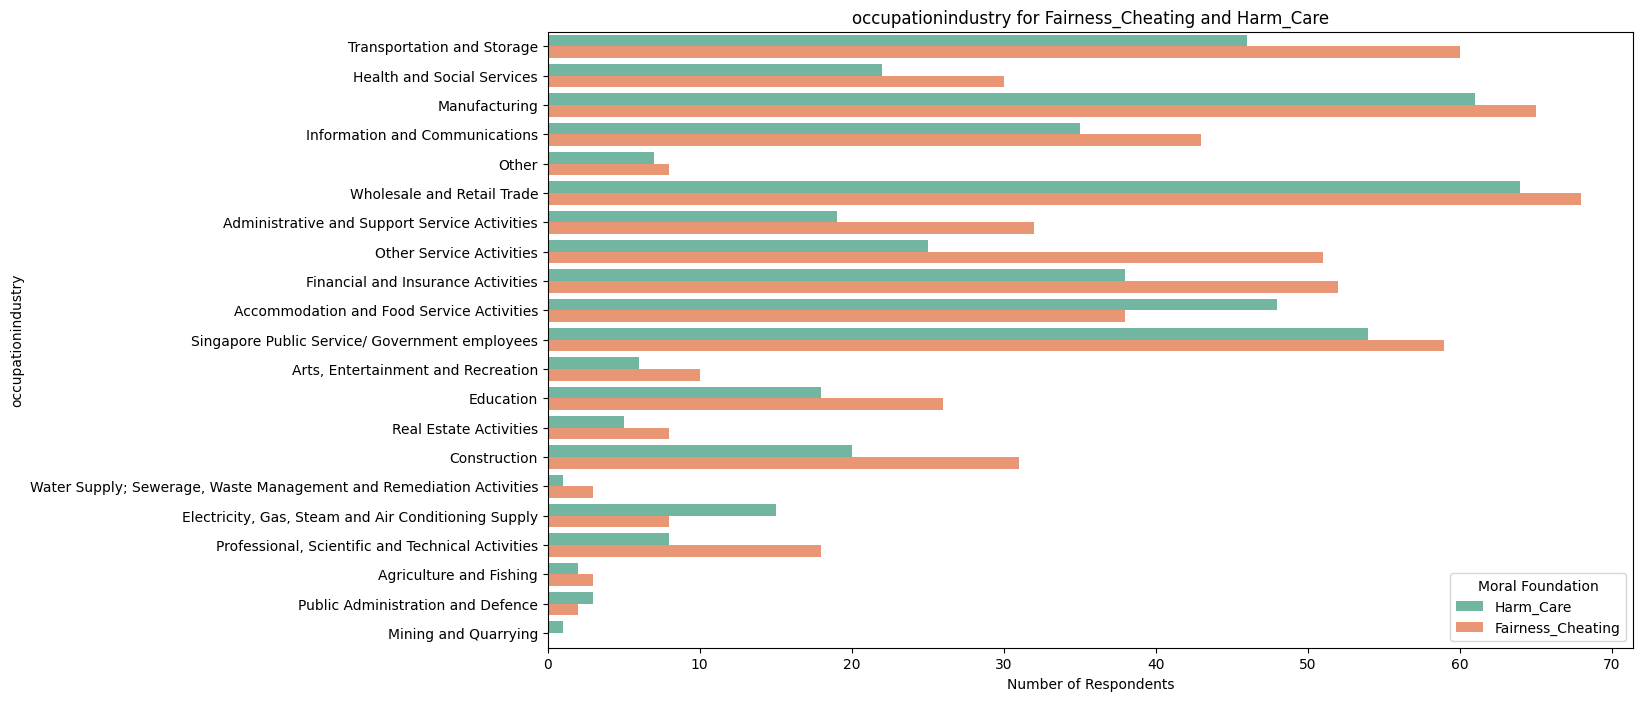

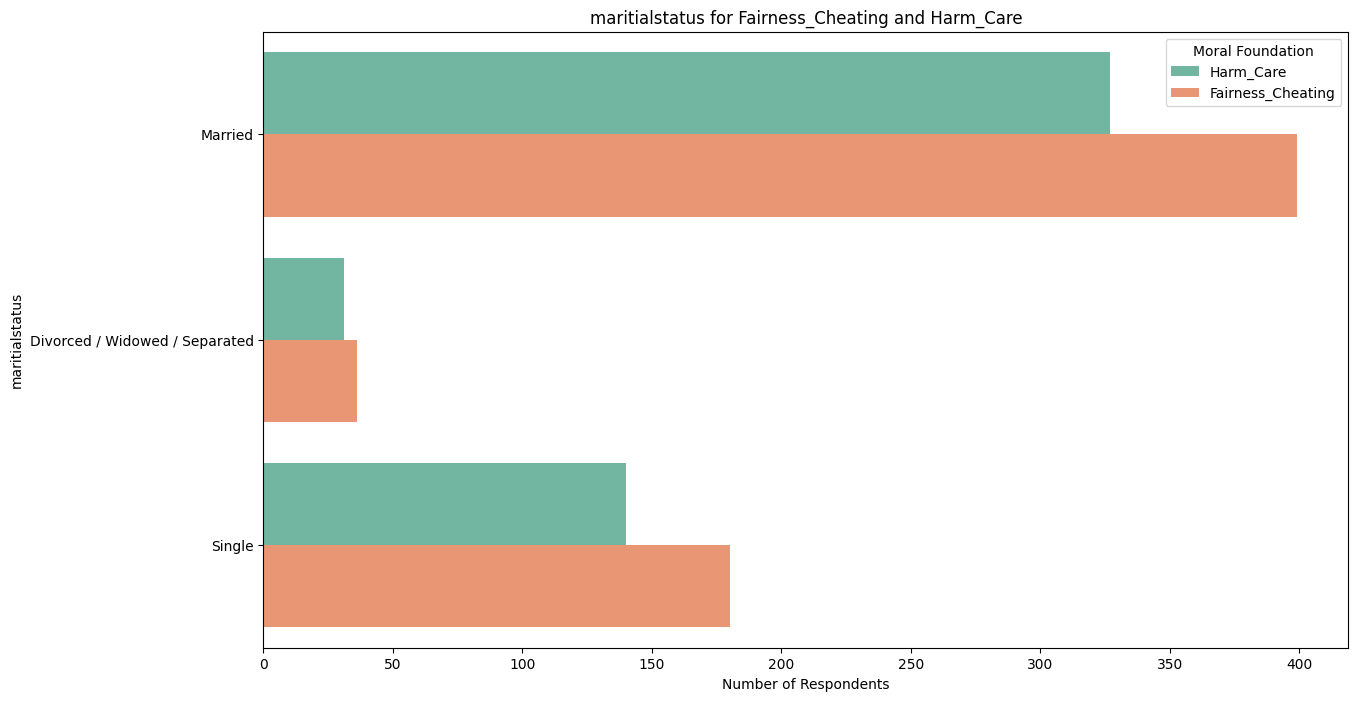

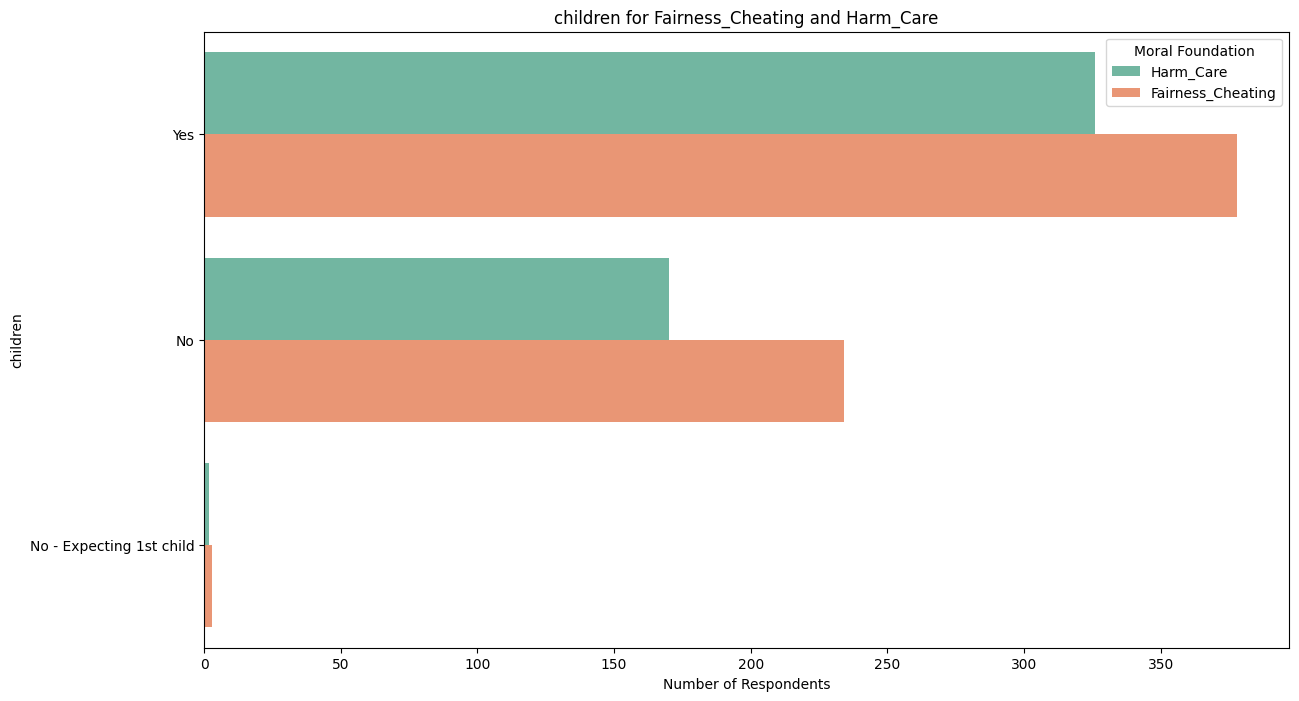

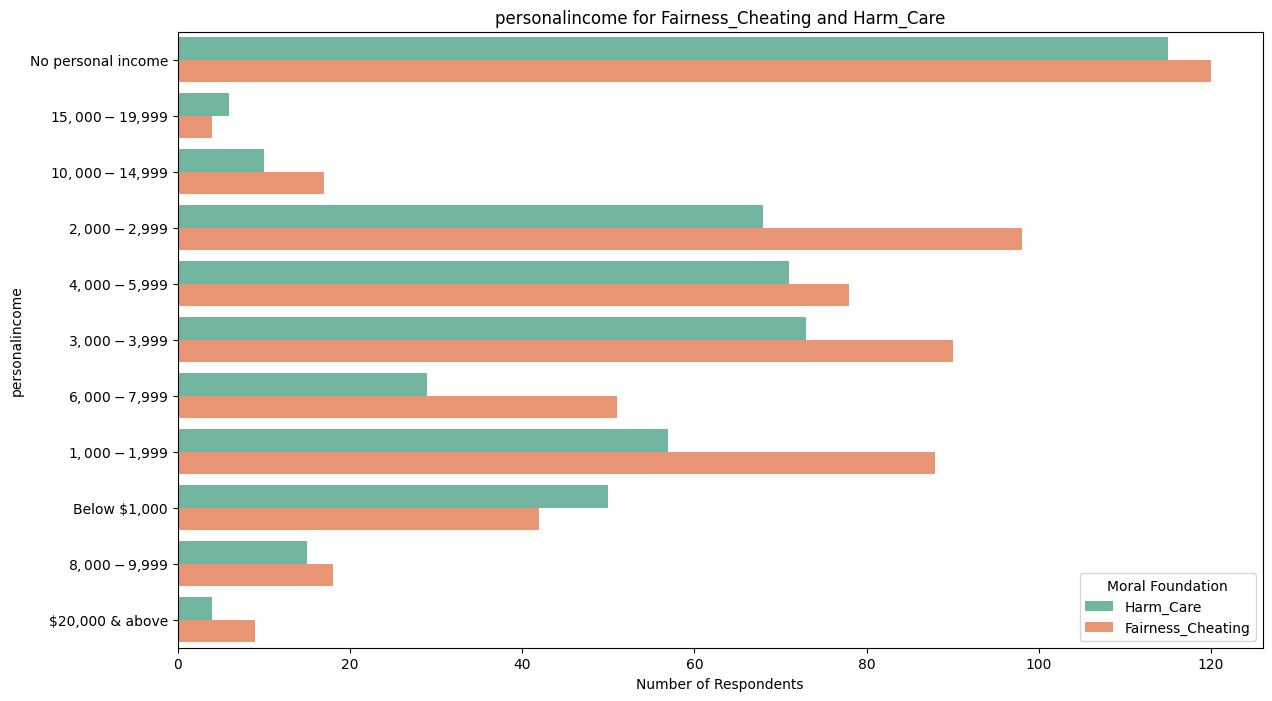

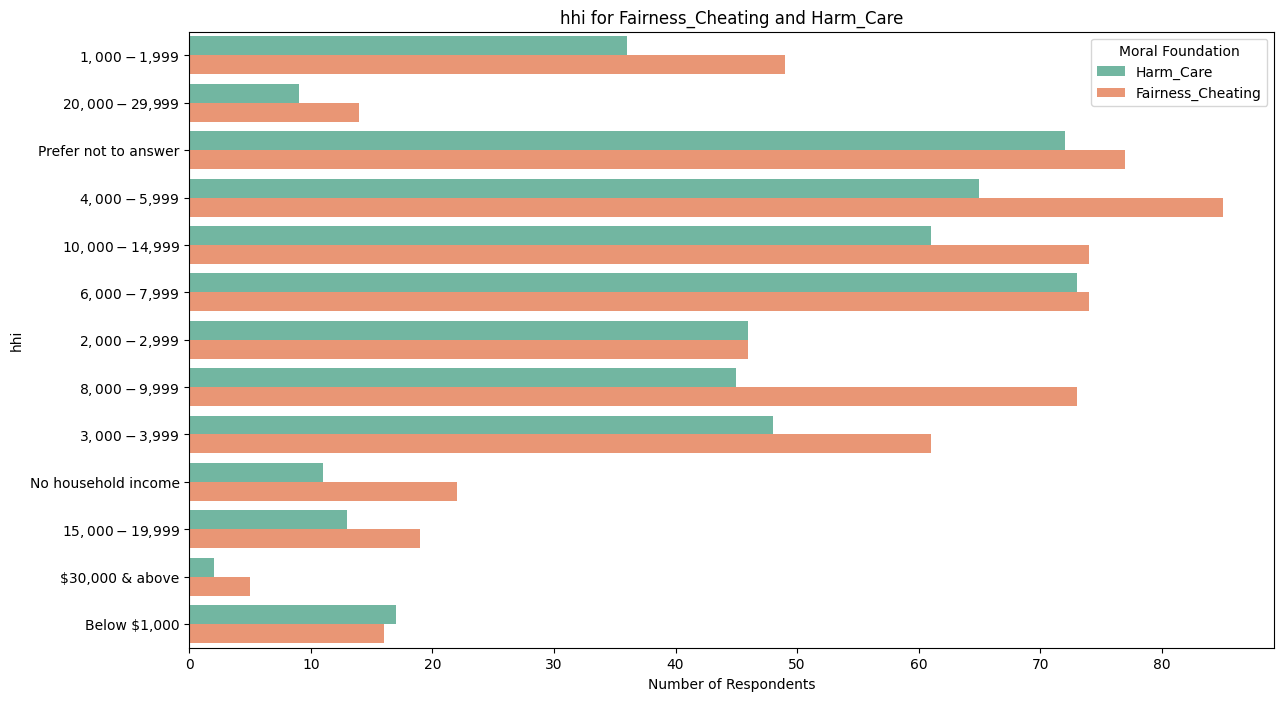

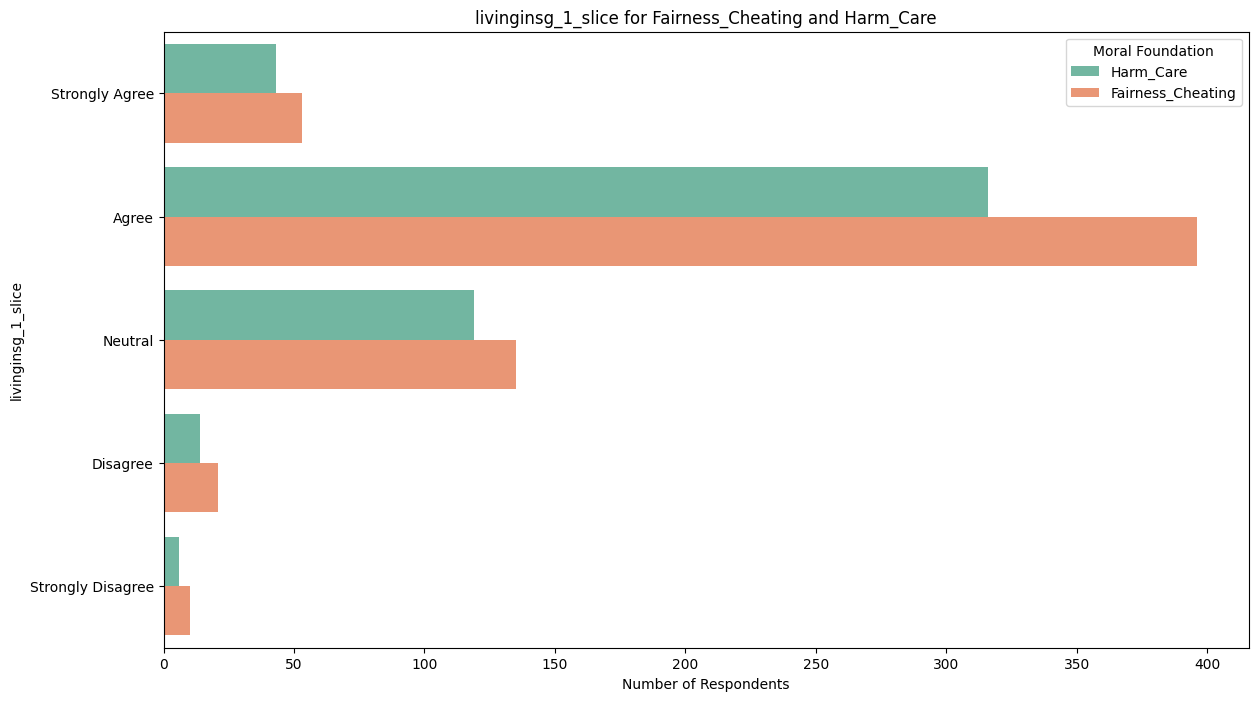

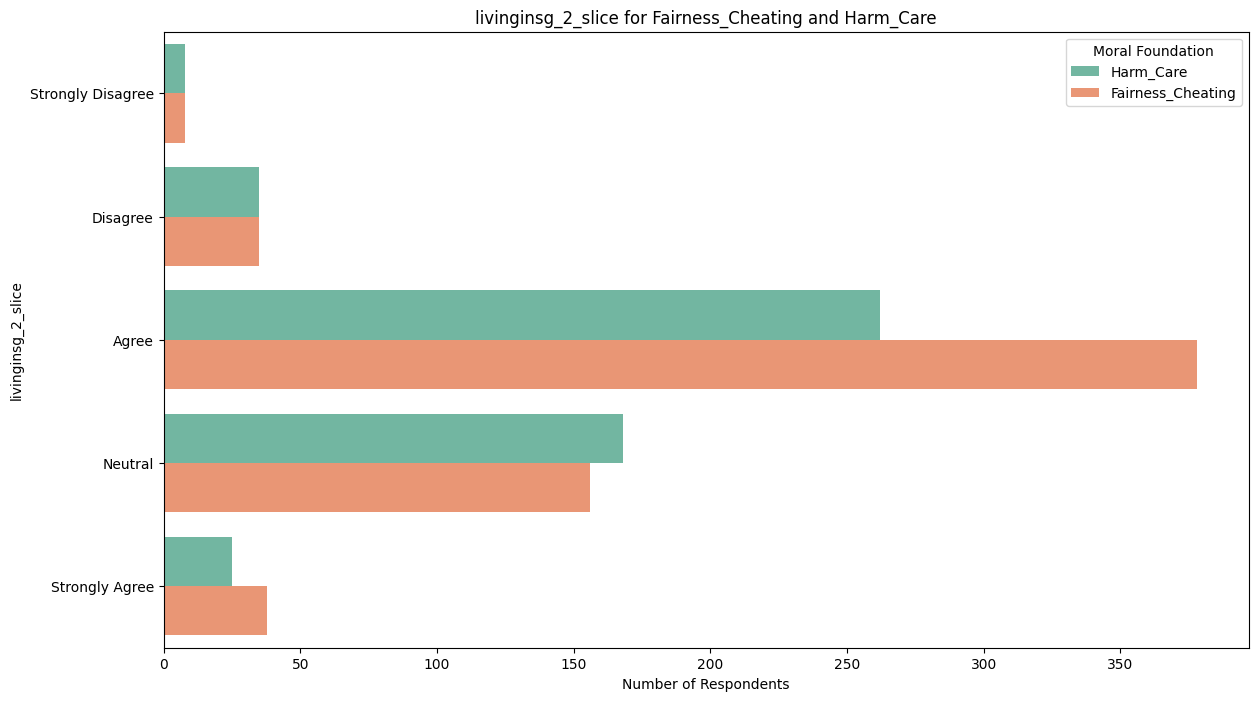

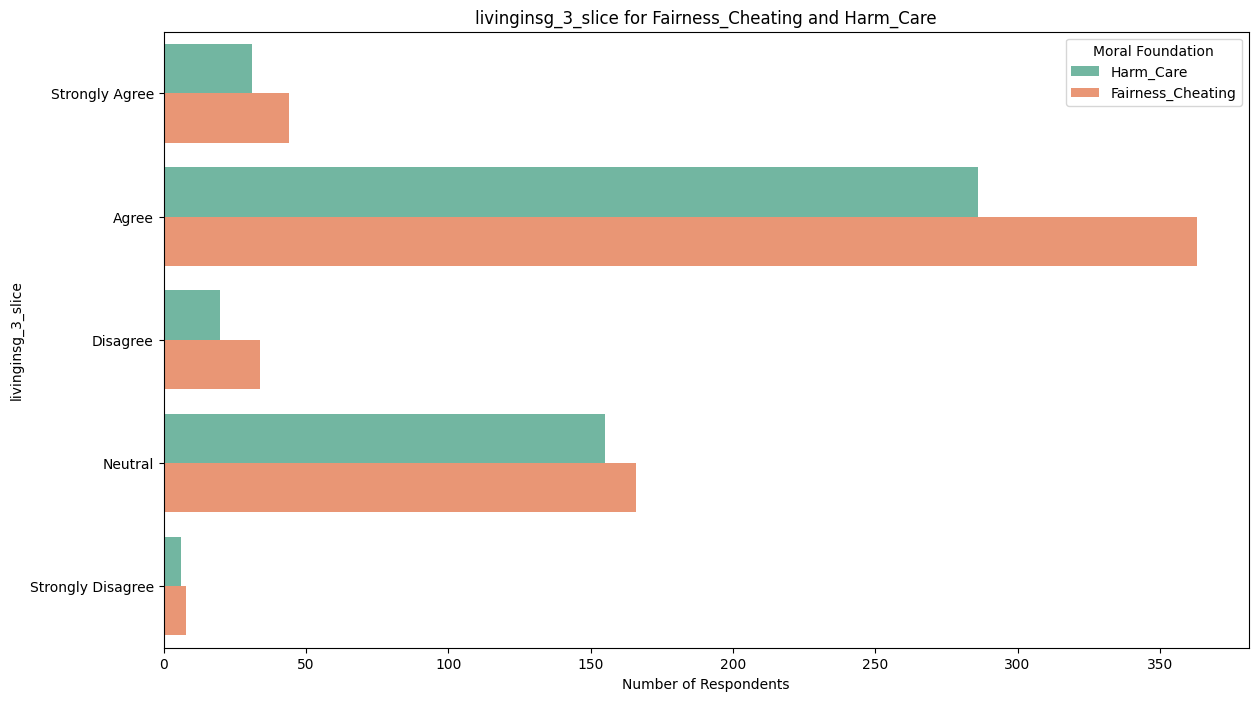

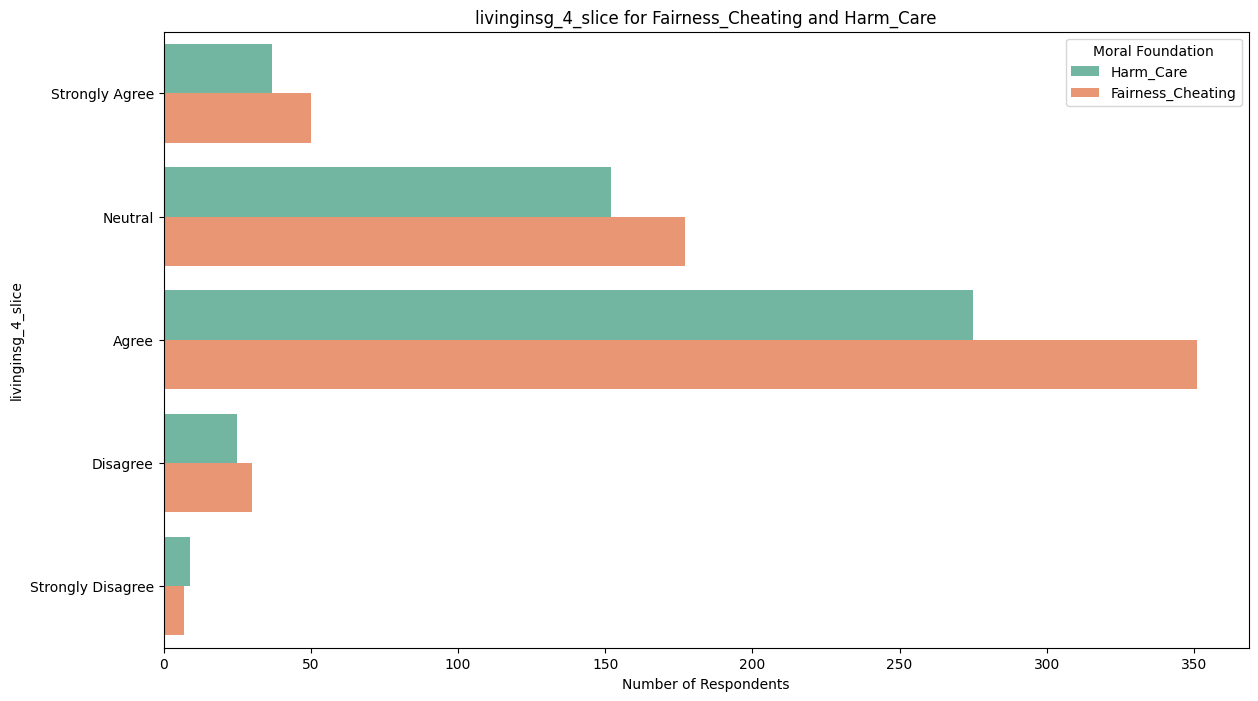

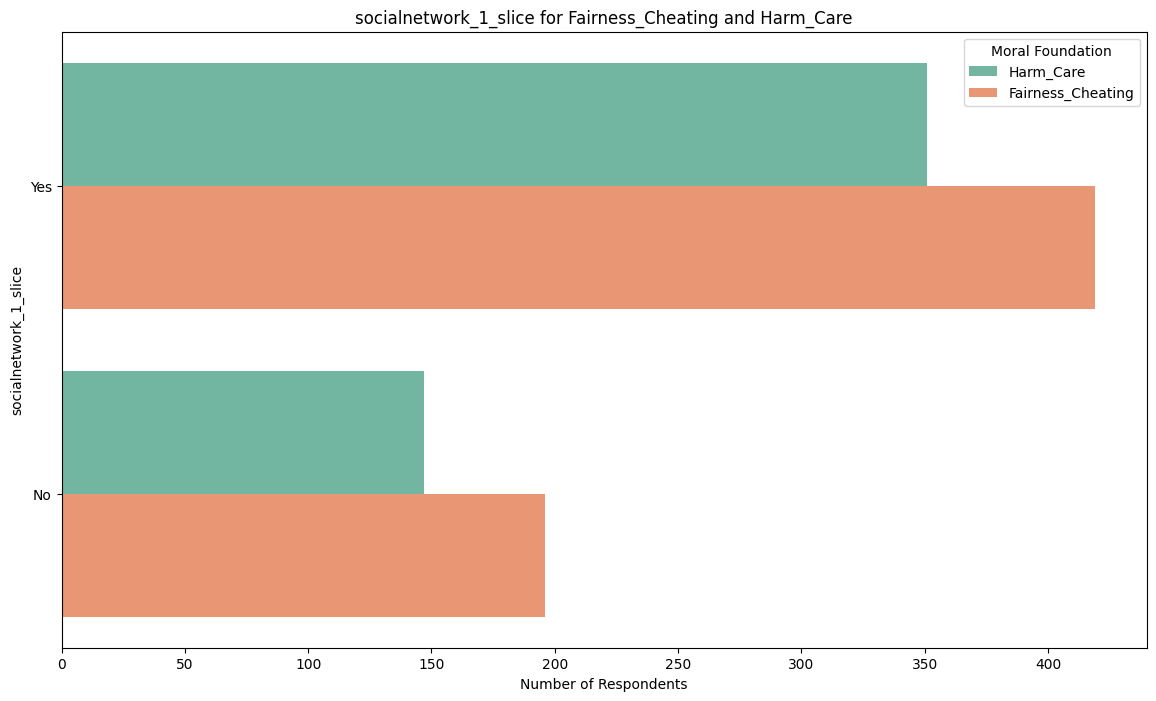

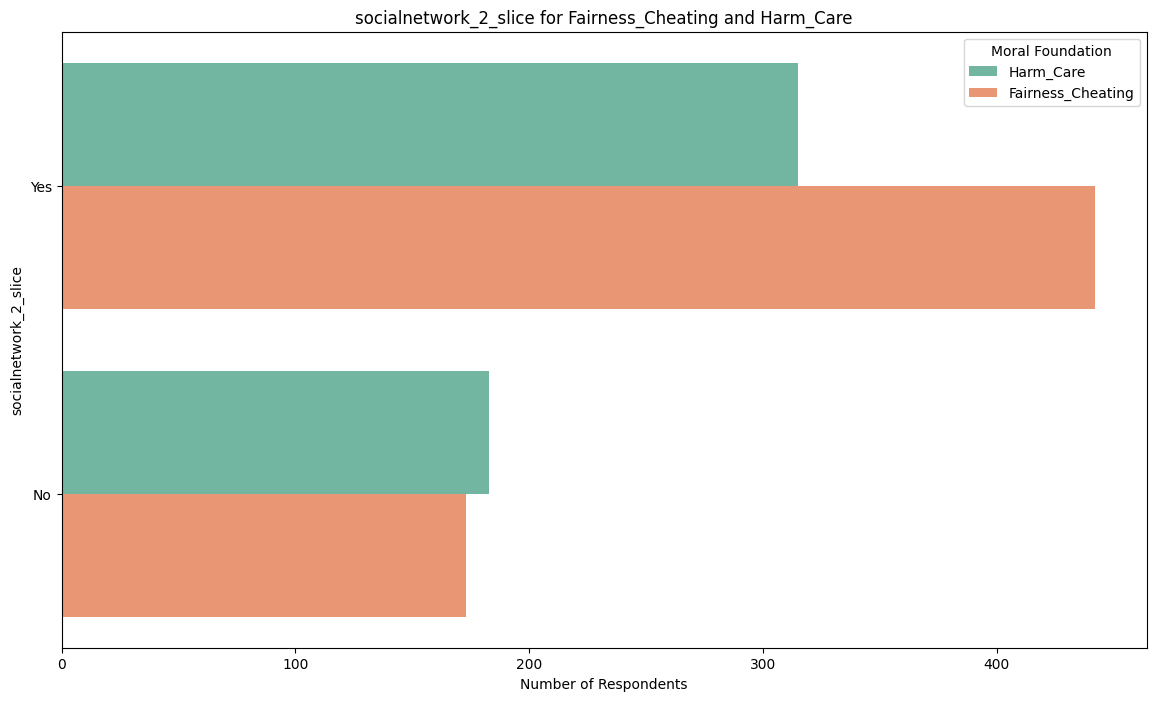

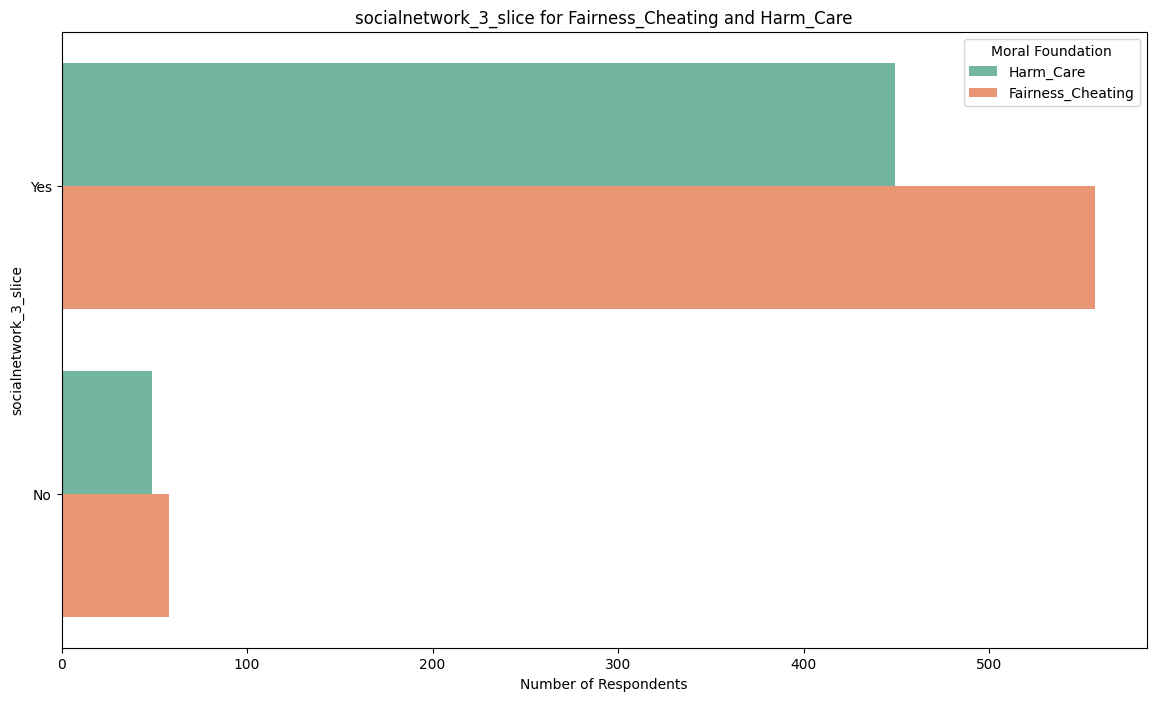

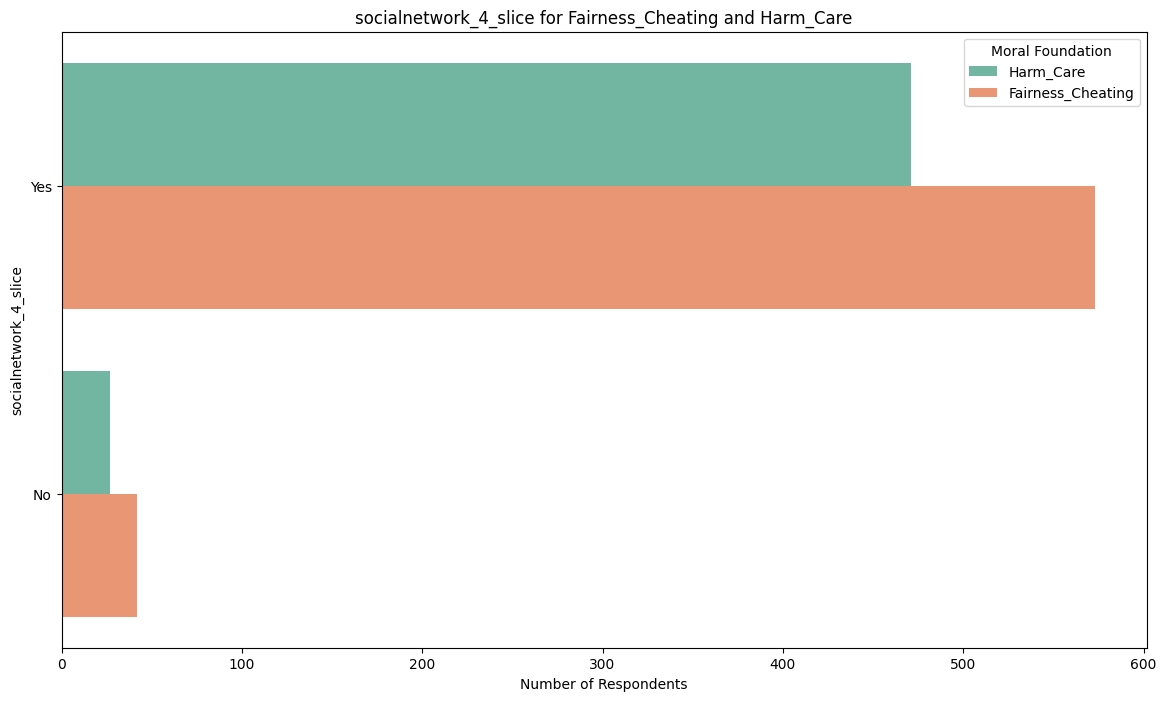

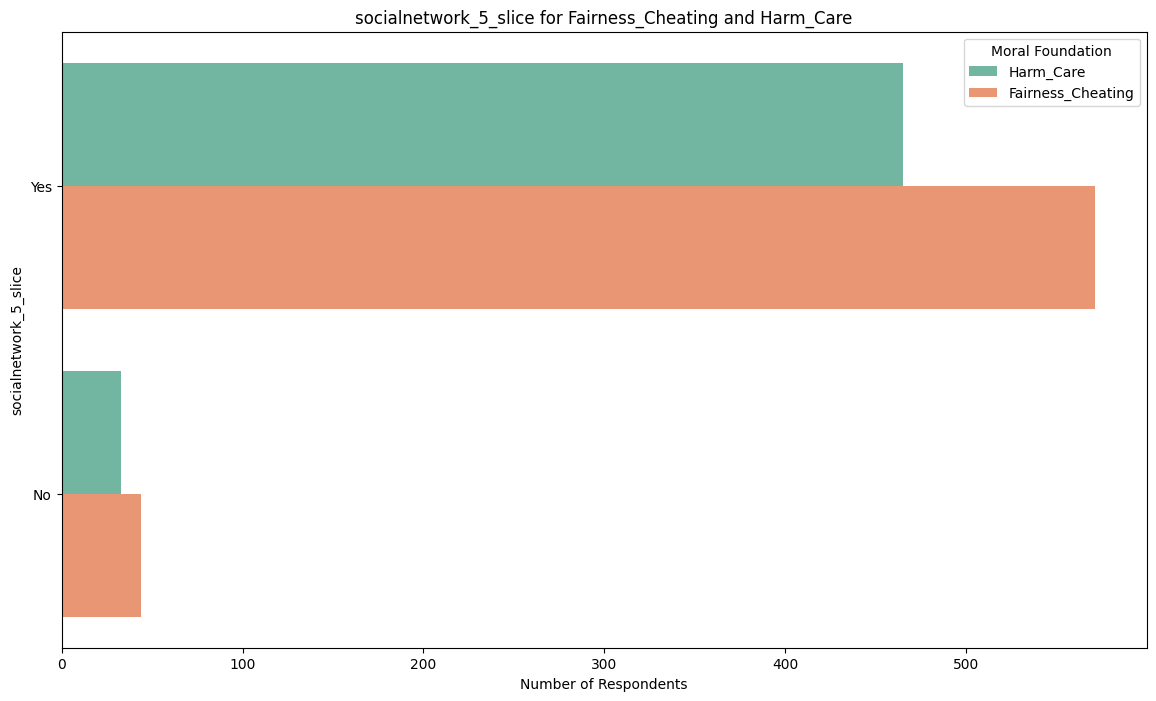

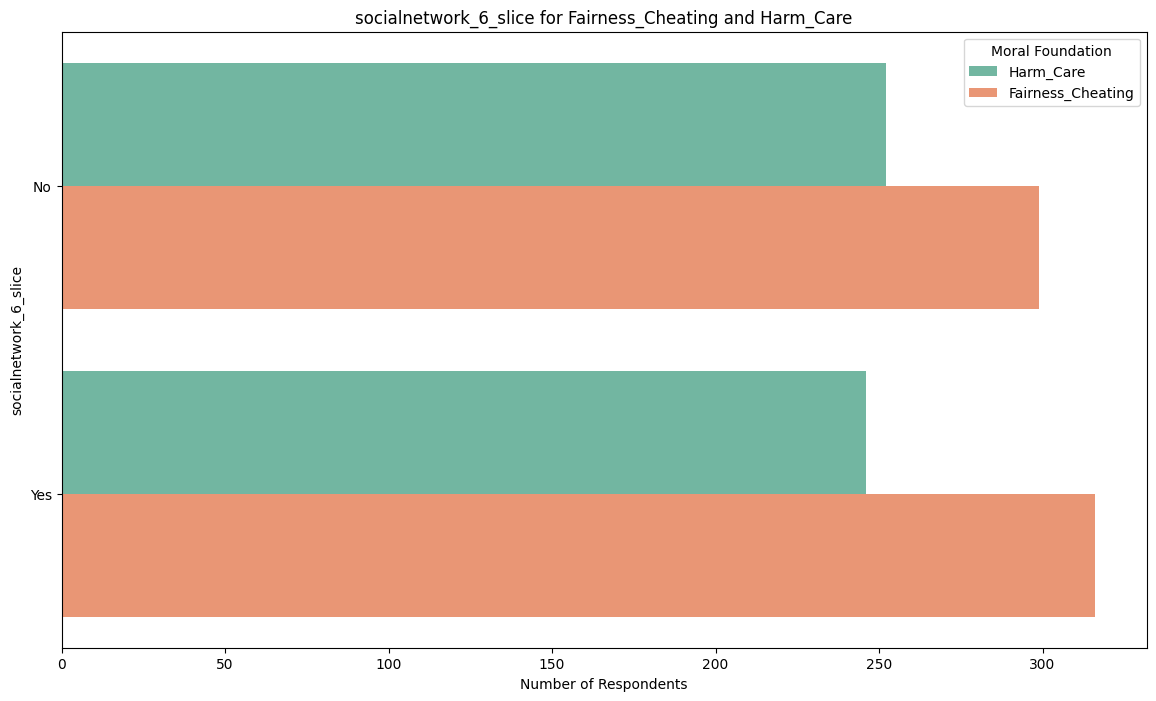

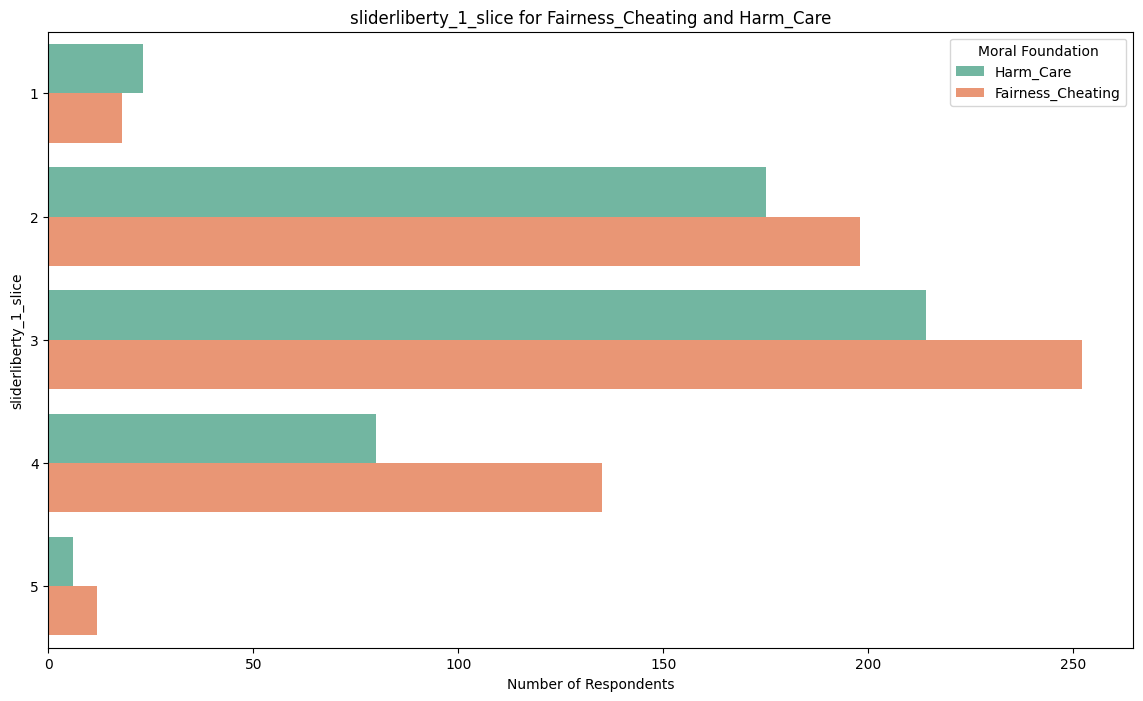

In [11]:
# Combine the data for Fairness_Cheating and Harm_Care
combined_df = filtered_df[filtered_df['md_segment'].isin(['Fairness_Cheating', 'Harm_Care'])]

# Function to plot demographic insights for the combined moral foundations
def plot_demographic_insights(df, column, title):
    plt.figure(figsize=(14, 8))
    sns.countplot(data=df, y=column, hue='md_segment', palette='Set2')
    plt.title(title)
    plt.xlabel('Number of Respondents')
    plt.ylabel(column)
    plt.legend(title='Moral Foundation')
    plt.show()

# Columns to analyze
columns_to_analyze = [
    'occstatus', 'highestlevel', 'occupationindustry',
    'maritialstatus', 'children', 'personalincome', 'hhi', 
    'livinginsg_1_slice', 'livinginsg_2_slice', 'livinginsg_3_slice', 
    'livinginsg_4_slice', 'socialnetwork_1_slice', 'socialnetwork_2_slice', 
    'socialnetwork_3_slice', 'socialnetwork_4_slice', 'socialnetwork_5_slice', 
    'socialnetwork_6_slice', 'sliderliberty_1_slice'
]

# Plotting for combined Fairness_Cheating and Harm_Care
for column in columns_to_analyze:
    plot_demographic_insights(combined_df, column, f'{column} for Fairness_Cheating and Harm_Care')